In [2]:
!git clone https://github.com/I-m-Parthian/Monument-Recognition.git

Cloning into 'Monument-Recognition'...
remote: Enumerating objects: 2775, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2775 (delta 8), reused 0 (delta 0), pack-reused 2760
Receiving objects: 100% (2775/2775), 28.60 MiB | 25.18 MiB/s, done.
Resolving deltas: 100% (2560/2560), done.


In [3]:
from PIL import Image
import os
dataset_dir = '/content/Monument-Recognition/Dataset'
img_size = None
num_classes = 0
for class_dir in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, class_dir)):
        num_classes += 1
        for img_file in os.listdir(os.path.join(dataset_dir, class_dir)):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(dataset_dir, class_dir, img_file)
                with Image.open(img_path) as img:
                    if img_size is None:
                        img_size = img.size
                    elif img_size != img.size:
                        print('Error: Images have different sizes')
                        break
print('Image size:', img_size)
print('Number of classes:', num_classes)


Image size: (64, 64)
Number of classes: 3


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
train_data_dir = '/content/Monument-Recognition/Dataset/1.Train'
#val_data_dir = 'x/val'
test_data_dir = '/content/Monument-Recognition/Dataset/Test'
img_size = (64, 64)
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
#val_generator = val_datagen.flow_from_directory(val_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 1925 images belonging to 49 classes.
Found 623 images belonging to 49 classes.


In [8]:
base_model = VGG16(input_shape=img_size + (3,), include_top=False)
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit_generator(train_generator, epochs=10, validation_data=train_generator)

Epoch 1/10


<ipython-input-17-456135e92843>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10, validation_data=train_generator)


61/61 [==============================] - 231s 4s/step - loss: 2.9819 - accuracy: 0.2556 - val_loss: 1.8289 - val_accuracy: 0.5132
Epoch 2/10
61/61 [==============================] - 242s 4s/step - loss: 1.6107 - accuracy: 0.5621 - val_loss: 1.0967 - val_accuracy: 0.6899
Epoch 3/10
61/61 [==============================] - 240s 4s/step - loss: 1.1518 - accuracy: 0.6769 - val_loss: 0.8574 - val_accuracy: 0.7496
Epoch 4/10
61/61 [==============================] - 231s 4s/step - loss: 0.8539 - accuracy: 0.7522 - val_loss: 0.6618 - val_accuracy: 0.8052
Epoch 5/10
61/61 [==============================] - 175s 3s/step - loss: 0.6798 - accuracy: 0.7958 - val_loss: 0.5042 - val_accuracy: 0.8582
Epoch 6/10
61/61 [==============================] - 231s 4s/step - loss: 0.6115 - accuracy: 0.8192 - val_loss: 0.4744 - val_accuracy: 0.8644
Epoch 7/10
61/61 [==============================] - 175s 3s/step - loss: 0.5198 - accuracy: 0.8462 - val_loss: 0.3837 - val_accuracy: 0.8868
Epoch 8/10
61/61 [======

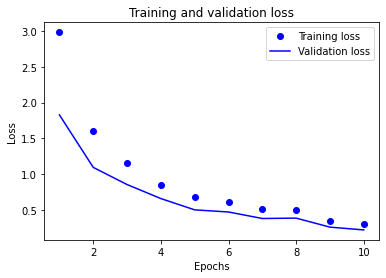

In [39]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)
model.save('monument_classifier.h5')

<ipython-input-18-70011a08b354>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator)


Test accuracy: 0.7223113775253296


Testing the model on shuffled image

In [19]:
model = tf.keras.models.load_model('monument_classifier.h5')

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image = load_img('/content/Monument-Recognition/Dataset/1.Train/Fatehpur Sikri Fort/7689ipok,.jpg', target_size=(64, 64))
img = img_to_array(image)
img = img.reshape((1,) + img.shape)
img /= 255.

In [21]:
prediction = model.predict(img)

1/1 [==============================] - 0s 240ms/step


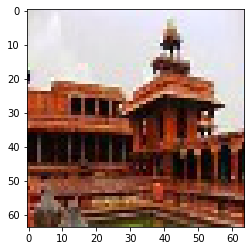

Fatehpur Sikri Fort


In [23]:
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
monument_name = inv_class_indices[np.argmax(prediction)]
from skimage import io
img = io.imread('/content/Monument-Recognition/Dataset/1.Train/Fatehpur Sikri Fort/7689ipok,.jpg')
plt.imshow(img)
plt.show()
print(monument_name)

Test on Custom Image

In [40]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/content/monument_classifier.h5')
img_path = '/content/33c6adde-8b32-49a3-b06b-0e1f38b98651.jpg'
img = Image.open(img_path).resize((64, 64))
x = np.array(img, dtype=np.float32) 
x = np.expand_dims(x, axis=0)
x /= 255.0
pred = model.predict(x)
print(pred)

1/1 [==============================] - 0s 227ms/step
[[7.38389324e-04 2.92510936e-06 1.35850900e-10 5.12179910e-10
  7.14595558e-07 1.01556363e-08 2.28276189e-08 2.80398638e-08
  7.69451916e-08 4.76199943e-07 3.88269195e-09 1.16529882e-05
  1.13570602e-08 2.98009536e-06 2.86046293e-06 2.63110132e-06
  1.71891645e-09 1.11821684e-10 6.99162722e-01 6.49602665e-03
  2.71134848e-08 3.16362531e-07 9.49933019e-05 2.57942634e-06
  1.54327263e-05 1.44393722e-04 3.26441068e-07 1.58702060e-05
  2.56791509e-06 9.60774429e-08 9.11373536e-06 3.42379991e-08
  5.33026250e-05 6.58187247e-08 1.32253464e-09 2.38135490e-05
  1.36609257e-08 1.10931019e-07 1.44239436e-06 9.18144508e-07
  1.56792102e-03 1.70823489e-06 3.83094459e-11 7.42252593e-10
  1.47260366e-07 1.01301190e-08 1.21610828e-08 3.32252705e-04
  2.91310996e-01]]


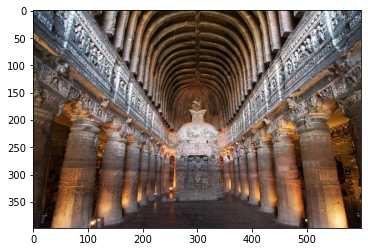

ajanta caves


In [41]:
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
monument_name = inv_class_indices[np.argmax(pred)]
from skimage import io
img = io.imread('/content/33c6adde-8b32-49a3-b06b-0e1f38b98651.jpg')
plt.imshow(img)
plt.show()
print(monument_name)